# Strategy Research

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv(
    "C:/Users/USER/Documents/QQQ Project/data/processed/full_QQQ_data.csv"
)


# Ensure numeric
cols = ['Open','High','Low','Close','Volume']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=['Open','High','Low','Close'])

# Moving Averages
df['MA20'] = df['Close'].rolling(20).mean()
df['MA50'] = df['Close'].rolling(50).mean()
df['MA100'] = df['Close'].rolling(100).mean()
df['MA200'] = df['Close'].rolling(200).mean()


In [ ]:
df.to_csv()

# Hypothesis Testing , QQQ has upward drift

H0: mean =  0

H1: mean > 0 (bigger than 0)

In [2]:
df['LogRet'] = np.log(df['Close'] / df['Close'].shift())

log_ret = df['LogRet'].dropna()

t_stat, p_value = ttest_1samp(log_ret, 0)
one_sided_p = p_value/2 # divide by 2 because our h1 > 0 

print("One-Sided p-value:", one_sided_p)

if one_sided_p < 0.05:
    print('QQQ has statistically significant upward drift.')
else:
    print('QQQ has no statistically significant upward drift.')


One-Sided p-value: 0.028395486812063588
QQQ has statistically significant upward drift.


In [3]:
df['TrendAligned'] = (
    (df['MA20'] > df['MA50']) &
    (df['MA50'] > df['MA100']) &
    (df['MA100'] > df['MA200'])
)

trend_ratio = df['TrendAligned'].mean()

print("Trend Alignment Frequency:", trend_ratio)


Trend Alignment Frequency: 0.44427890345649584


# Take Profit Optimization

This experiment measures the profit potential of MA20 pullback cycles in QQQ during confirmed uptrends. A swing is defined from the moment price closes below MA20 (entry on next day open) until the next time price closes below MA20 again. The lowest intraday low after entry represents the swing bottom, while the swing top is determined using a 5–10 day rolling highest high to avoid noise and one-day spikes. The swing percentage is calculated as:

Swing% = (Highest High/ Lowest Low) -1

In [4]:
ten_years = df.loc[df.index >= df.index.max() - pd.Timedelta(days=10*365)].copy()



Buy signal

In [5]:
signals = ten_years[
    (ten_years['TrendAligned']) &
    (ten_years['Close'] < ten_years['MA20'])
].copy()

signals['EntryPrice'] = signals['Close'].shift(-1)


In [6]:
import numpy as np
import pandas as pd

ROLLING_WINDOW = 10     # recommended: 5–10
swings = []

df10 = ten_years  # rename for convenience

for i in range(len(df10)-1):

    today = df10.iloc[i]

    # Entry condition: MA20 dip inside aligned uptrend
    if today['Close'] < today['MA20'] and today['TrendAligned']:

        entry_idx = i + 1
        if entry_idx >= len(df10):
            break

        swing_lows = []
        swing_highs = []

        # Entry bar
        entry_row = df10.iloc[entry_idx]
        swing_lows.append(entry_row['Low'])
        swing_highs.append(entry_row['High'])

        phase = "LOW_PHASE"

        for j in range(entry_idx+1, len(df10)):

            row = df10.iloc[j]

            swing_lows.append(row['Low'])
            swing_highs.append(row['High'])

            # Pullback finished → rally starts
            if phase == "LOW_PHASE" and row['Close'] > row['MA20']:
                phase = "HIGH_PHASE"

            # Swing ends at next MA20 dip
            elif phase == "HIGH_PHASE" and row['Close'] < row['MA20']:

                lowest_low = min(swing_lows)

                highs_series = pd.Series(swing_highs)
                confirmed_highs = highs_series.rolling(
                    ROLLING_WINDOW, min_periods=1
                ).max()

                highest_high = confirmed_highs.max()

                swing_pct = (highest_high / lowest_low) - 1

                if np.isfinite(swing_pct):
                    swings.append(swing_pct)

                break

swings = np.array(swings)


In [7]:
print("Number of swings (10 years):", len(swings))
print("Median swing:", round(np.percentile(swings, 50), 4))
print("75th percentile:", round(np.percentile(swings, 75), 4))
print("90th percentile:", round(np.percentile(swings, 90), 4))



Number of swings (10 years): 363
Median swing: 0.0718
75th percentile: 0.1185
90th percentile: 0.1667


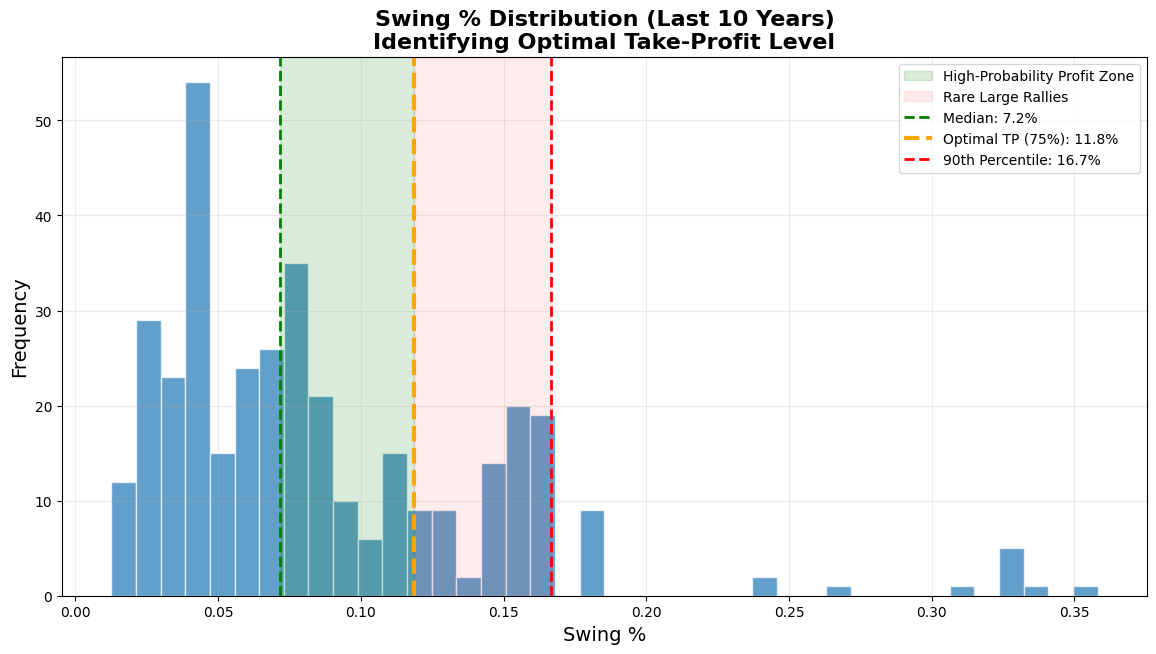

In [8]:
import matplotlib.pyplot as plt

# Clean swings
swings = swings[np.isfinite(swings)]

median = np.percentile(swings, 50)
p75 = np.percentile(swings, 75)
p90 = np.percentile(swings, 90)

plt.figure(figsize=(14,7))
plt.hist(swings, bins=40, color='#1f77b4', alpha=0.7, edgecolor='white')

plt.axvspan(median, p75, color='green', alpha=0.15, label='High-Probability Profit Zone')
plt.axvspan(p75, p90, color='red', alpha=0.08, label='Rare Large Rallies')

plt.axvline(median, color='green', linestyle='--', linewidth=2, label=f"Median: {median:.1%}")
plt.axvline(p75, color='orange', linestyle='--', linewidth=3, label=f"Optimal TP (75%): {p75:.1%}")
plt.axvline(p90, color='red', linestyle='--', linewidth=2, label=f"90th Percentile: {p90:.1%}")

plt.title("Swing % Distribution (Last 10 Years)\nIdentifying Optimal Take-Profit Level",
          fontsize=16, fontweight='bold')
plt.xlabel("Swing %", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(alpha=0.25)
plt.legend()
plt.show()


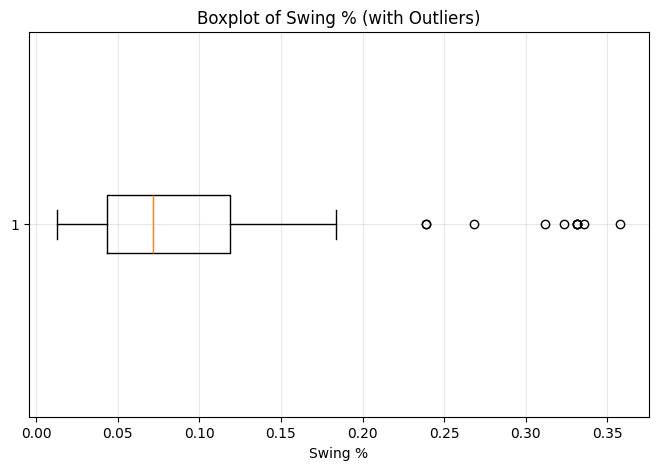

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ensure clean array
swings = np.array(swings)
swings = swings[np.isfinite(swings)]
plt.figure(figsize=(8,5))
plt.boxplot(swings, vert=False)
plt.title("Boxplot of Swing % (with Outliers)")
plt.xlabel("Swing %")
plt.grid(alpha=0.3)
plt.show()


In [10]:
cutoff = np.percentile(swings, 95)
trimmed = swings[swings <= cutoff]


In [11]:
median_trim = np.percentile(trimmed, 50)
p60_trim = np.percentile(trimmed, 60)
p75_trim = np.percentile(trimmed, 75)
mean_trim = np.mean(trimmed)
p90_trim = np.percentile(trimmed, 90)

print("Trimmed sample size:", len(trimmed))
print("Trimmed Median:", round(median_trim, 4))
print("Trimmed Mean:", round(mean_trim, 4))
print("Trimmed 60th percentile:", round(p60_trim, 4))
print("Trimmed 75th percentile:", round(p75_trim, 4))
print("Trimmed 90th percentile:", round(p90_trim, 4))


Trimmed sample size: 344
Trimmed Median: 0.0693
Trimmed Mean: 0.078
Trimmed 60th percentile: 0.0782
Trimmed 75th percentile: 0.1108
Trimmed 90th percentile: 0.1553


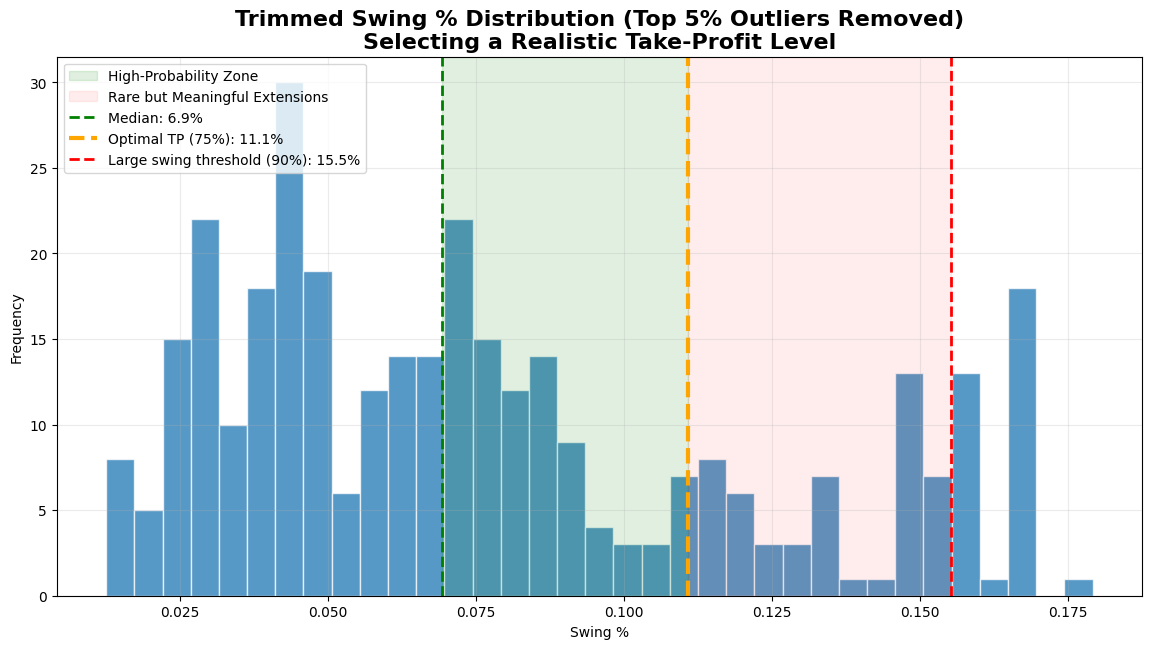

In [12]:
plt.figure(figsize=(14,7))

plt.hist(trimmed, bins=35, color='#1f77b4', alpha=0.75, edgecolor='white')

# Highlight zones
plt.axvspan(median_trim, p75_trim, color='green', alpha=0.12, label='High-Probability Zone')
plt.axvspan(p75_trim, p90_trim, color='red', alpha=0.07, label='Rare but Meaningful Extensions')

# Lines
plt.axvline(median_trim, color='green', linestyle='--', linewidth=2,
            label=f"Median: {median_trim:.1%}")
plt.axvline(p75_trim, color='orange', linestyle='--', linewidth=3,
            label=f"Optimal TP (75%): {p75_trim:.1%}")
plt.axvline(p90_trim, color='red', linestyle='--', linewidth=2,
            label=f"Large swing threshold (90%): {p90_trim:.1%}")

plt.title("Trimmed Swing % Distribution (Top 5% Outliers Removed)\nSelecting a Realistic Take-Profit Level",
          fontsize=16, fontweight='bold')
plt.xlabel("Swing %")
plt.ylabel("Frequency")
plt.grid(alpha=0.25)
plt.legend()
plt.show()


75 percentile and median are selected for testing

,num_trades,win_rate,avg_win,avg_loss,avg_pnl_per_trade,expectancy,profit_factor,final_capital,total_return,CAGR,Sharpe,MaxDrawdown
TP,,,,,,,,,,,,
0.071820,182,0.505495,178.332392,-142.543749,19.657377,19.657377,1.278873,13577.642617,0.357764,0.031095,0.279559,-0.718162
0.110816,182,0.494505,157.729277,-134.335119,10.092330,10.092330,1.148623,11836.803973,0.183680,0.017027,0.186233,-0.733313


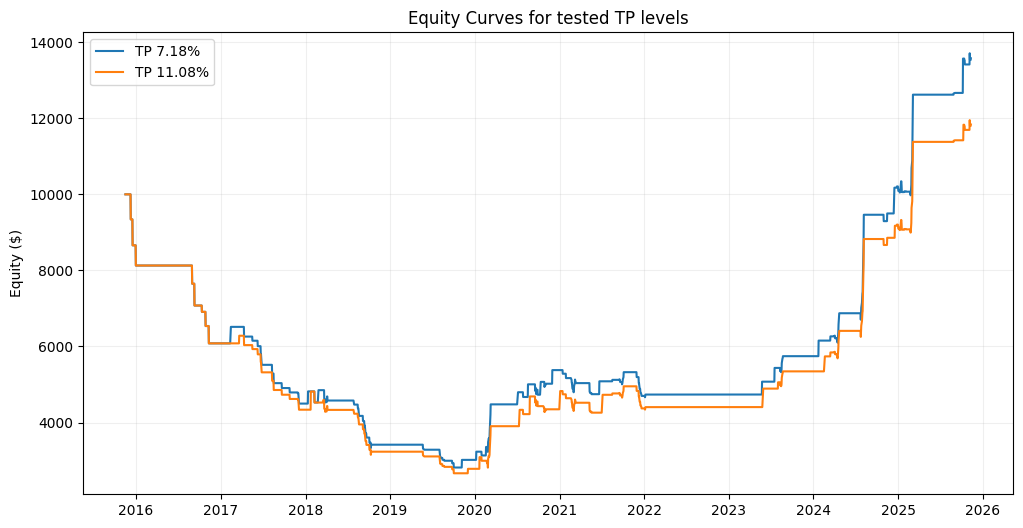


TP = 7.18% | Trades = 182
exit_reason
SL            111
Close<MA20     54
TP             16
EOD             1
Name: count, dtype: int64


,entry_date,entry_price,exit_date,exit_price,size,pnl,gross_pnl,commission,exit_reason,trade_length
0,2015-12-04,112.906423,2015-12-09,105.474710,88.568920,-658.218862,-658.218862,0.0,Close<MA20,5
1,2015-12-10,113.206577,2015-12-17,104.942162,82.519774,-681.977613,-681.977613,0.0,Close<MA20,7
2,2015-12-18,111.685812,2015-12-31,104.831584,77.537185,-531.457600,-531.457600,0.0,Close<MA20,13
3,2016-08-26,116.708327,2016-08-30,109.852113,69.646667,-477.512432,-477.512432,0.0,Close<MA20,4
4,2016-08-31,116.438187,2016-09-09,107.703316,65.707254,-573.944405,-573.944405,0.0,Close<MA20,9



TP = 11.08% | Trades = 182
exit_reason
SL            111
Close<MA20     63
TP              7
EOD             1
Name: count, dtype: int64


,entry_date,entry_price,exit_date,exit_price,size,pnl,gross_pnl,commission,exit_reason,trade_length
0,2015-12-04,112.906423,2015-12-09,105.474710,88.568920,-658.218862,-658.218862,0.0,Close<MA20,5
1,2015-12-10,113.206577,2015-12-17,104.942162,82.519774,-681.977613,-681.977613,0.0,Close<MA20,7
2,2015-12-18,111.685812,2015-12-31,104.831584,77.537185,-531.457600,-531.457600,0.0,Close<MA20,13
3,2016-08-26,116.708327,2016-08-30,109.852113,69.646667,-477.512432,-477.512432,0.0,Close<MA20,4
4,2016-08-31,116.438187,2016-09-09,107.703316,65.707254,-573.944405,-573.944405,0.0,Close<MA20,9


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIG ===
INITIAL_CAPITAL = 10000.0
ROLLING_YEARS = 10
SLIPPAGE = 0.0005      # 0.05% slippage per fill (adjust)
COMMISSION = 0.0       # flat commission per trade (dollars)
TP_LIST = [p50_trim if 'p50_trim' in globals() else np.percentile(swings,50),
           p75_trim if 'p75_trim' in globals() else np.percentile(swings,75)]
# If you already have median/75 values, set TP_LIST = [median, p75]

ASSUME_SL_HITS_FIRST = True  # if both SL & TP same day, SL assumed first (conservative)

# === PREP ===
# ensure df exists, with Date index and columns: Open, High, Low, Close, MA20, MA50, TrendAligned
df_bt = df.copy()
df_bt = df_bt.loc[df_bt.index >= df_bt.index.max() - pd.Timedelta(days=ROLLING_YEARS*365)].copy()
df_bt = df_bt.sort_index()

# clean numeric columns
for c in ['Open','High','Low','Close','MA20','MA50']:
    df_bt[c] = pd.to_numeric(df_bt[c], errors='coerce')

# Quick check
assert isinstance(df_bt.index, pd.DatetimeIndex), "df must have DatetimeIndex"

# Helper for performance metrics
def annualized_sharpe(equity_series, risk_free=0.0):
    # equity_series: pd.Series indexed by dates, forward filled; compute daily returns
    daily_ret = equity_series.pct_change().fillna(0)
    if daily_ret.std() == 0:
        return np.nan
    ann_ret = (1 + daily_ret.mean())**252 - 1
    ann_vol = daily_ret.std() * np.sqrt(252)
    return (ann_ret - risk_free) / ann_vol if ann_vol > 0 else np.nan

def max_drawdown(equity_series):
    cum = equity_series.fillna(method='ffill')
    peak = cum.cummax()
    dd = (cum - peak) / peak
    mdd = dd.min()
    return mdd

# Backtest engine
def run_backtest(tp_level):
    capital = INITIAL_CAPITAL
    equity_history = pd.Series(index=df_bt.index, dtype=float)
    equity_history.iloc[0] = capital

    trades = []
    i = 0
    n = len(df_bt)

    while i < n-1:
        today = df_bt.iloc[i]

        # entry signal: today close < MA20 and trend aligned
        if (today['Close'] < today['MA20']) and (today.get('TrendAligned', False)):
            entry_idx = i + 1
            if entry_idx >= n:
                break

            entry_row = df_bt.iloc[entry_idx]
            entry_price = float(entry_row['Open']) * (1 + SLIPPAGE)  # buy with slippage
            entry_date = df_bt.index[entry_idx]

            # invest full capital
            size = capital / entry_price

            swing_lows = [entry_row['Low']]
            swing_highs = [entry_row['High']]
            phase = "LOW_PHASE"
            exit_price = None
            exit_date = None
            exit_reason = None
            j = entry_idx

            while j < n:
                row = df_bt.iloc[j]
                cur_date = df_bt.index[j]

                # update intraday highs/lows tracking
                swing_lows.append(row['Low'])
                swing_highs.append(row['High'])

                # check stoploss first (conservative): intraday low breaches MA50
                if row['Low'] <= row['MA50']:
                    # execute at MA50 (conservative) with slippage
                    exit_price = float(row['MA50']) * (1 - SLIPPAGE)
                    exit_date = cur_date
                    exit_reason = 'SL'
                    break

                # check TP hit intraday
                tp_price = entry_price * (1 + tp_level)
                if row['High'] >= tp_price:
                    exit_price = tp_price * (1 - SLIPPAGE)  # filled with slippage
                    exit_date = cur_date
                    exit_reason = 'TP'
                    break

                # phase switch: low-phase -> high-phase when close > MA20
                if (phase == "LOW_PHASE") and (row['Close'] > row['MA20']):
                    phase = "HIGH_PHASE"

                # swing natural end: in high phase, close < MA20 -> end trade at close
                if (phase == "HIGH_PHASE") and (row['Close'] < row['MA20']):
                    exit_price = float(row['Close']) * (1 - SLIPPAGE)
                    exit_date = cur_date
                    exit_reason = 'Close<MA20'
                    break

                j += 1

            # if no exit found till end, force exit at final close
            if exit_price is None:
                last_row = df_bt.iloc[-1]
                exit_price = float(last_row['Close']) * (1 - SLIPPAGE)
                exit_date = df_bt.index[-1]
                exit_reason = 'EOD'

            # compute PnL and update capital
            gross_pnl = (exit_price - entry_price) * size
            commission_cost = COMMISSION
            capital = capital + gross_pnl - commission_cost

            trade = {
                'entry_date': entry_date, 'entry_price': entry_price,
                'exit_date': exit_date, 'exit_price': exit_price,
                'size': size, 'pnl': gross_pnl - commission_cost,
                'gross_pnl': gross_pnl, 'commission': commission_cost,
                'exit_reason': exit_reason,
                'trade_length': (exit_date - entry_date).days
            }
            trades.append(trade)

            # record equity at exit_date (we'll fill series later)
            equity_history.loc[exit_date] = capital

            # move i forward to after exit date index to avoid overlapping entry on same cycle
            # find index of exit_date
            i = df_bt.index.get_loc(exit_date)
            continue

        i += 1

    # fill equity history forward and backward fill first value
    equity_history = equity_history.fillna(method='ffill')
    equity_history.iloc[0] = equity_history.iloc[0] if not np.isnan(equity_history.iloc[0]) else INITIAL_CAPITAL
    equity_history = equity_history.fillna(method='ffill').fillna(INITIAL_CAPITAL)

    # Metrics
    trades_df = pd.DataFrame(trades)
    wins = trades_df[trades_df['pnl'] > 0]
    losses = trades_df[trades_df['pnl'] <= 0]

    num_trades = len(trades_df)
    win_rate = len(wins) / num_trades if num_trades > 0 else np.nan
    avg_win = wins['pnl'].mean() if len(wins) > 0 else 0.0
    avg_loss = losses['pnl'].mean() if len(losses) > 0 else 0.0
    avg_return_per_trade = trades_df['pnl'].mean() if num_trades > 0 else 0.0
    expectation = win_rate * (wins['pnl'].mean() if len(wins)>0 else 0) + (1-win_rate) * (losses['pnl'].mean() if len(losses)>0 else 0)
    profit_factor = wins['gross_pnl'].sum() / abs(losses['gross_pnl'].sum()) if len(losses)>0 else np.nan
    total_return = (capital - INITIAL_CAPITAL) / INITIAL_CAPITAL

    # annualized stats
    start_date = df_bt.index[0]
    end_date = df_bt.index[-1]
    years = (end_date - start_date).days / 365.25
    cagr = (capital / INITIAL_CAPITAL) ** (1/years) - 1 if years>0 else np.nan
    sharpe = annualized_sharpe(equity_history)
    mdd = max_drawdown(equity_history)

    summary = {
        'TP': tp_level,
        'num_trades': num_trades,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'avg_pnl_per_trade': avg_return_per_trade,
        'expectancy': expectation,
        'profit_factor': profit_factor,
        'final_capital': capital,
        'total_return': total_return,
        'CAGR': cagr,
        'Sharpe': sharpe,
        'MaxDrawdown': mdd
    }

    # also return trades_df and equity series for plotting
    return summary, trades_df, equity_history

# === RUN for both TP levels ===
results = []
trades_by_tp = {}
equity_by_tp = {}

for tp in TP_LIST:
    s, trades_df, equity_series = run_backtest(tp)
    results.append(s)
    trades_by_tp[f"{tp:.4f}"] = trades_df
    equity_by_tp[f"{tp:.4f}"] = equity_series

# Results table
res_df = pd.DataFrame(results).set_index('TP')
display(res_df)

# Plot equity curves
plt.figure(figsize=(12,6))
for k, eq in equity_by_tp.items():
    plt.plot(eq.index, eq.values, label=f"TP {float(k):.2%}")
plt.legend()
plt.title("Equity Curves for tested TP levels")
plt.ylabel("Equity ($)")
plt.grid(alpha=0.2)
plt.show()

# Trade count and exit reason breakdown for each TP
for k, trades_df in trades_by_tp.items():
    print(f"\nTP = {float(k):.2%} | Trades = {len(trades_df)}")
    if len(trades_df)>0:
        print(trades_df['exit_reason'].value_counts())
    display(trades_df.head())


,Trades,WinRate,AvgWin,AvgLoss,Expectancy,ProfitFactor,FinalCapital,TotalReturn,Sharpe,MaxDrawdown
TP,,,,,,,,,,
0.07,182,0.505495,27.333195,-23.591080,2.150861,1.184371,10391.456737,0.039146,0.257417,-0.115891
0.11,182,0.494505,28.141818,-23.423771,2.075696,1.175303,10377.776647,0.037778,0.234800,-0.112086


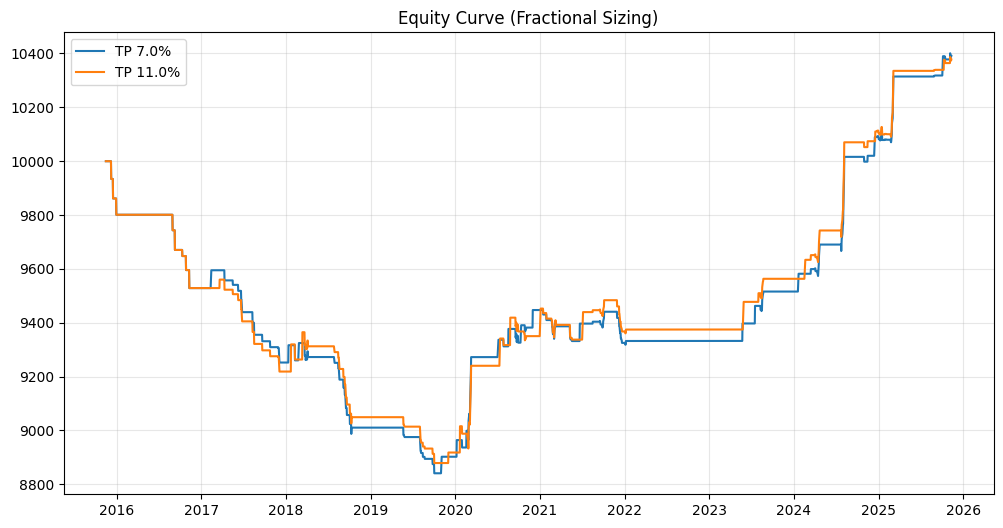

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIG ===
INITIAL_CAPITAL = 10000.0
RISK_FRACTION = 0.10       # <-- fraction of capital per trade (10%)
ROLLING_YEARS = 10
SLIPPAGE = 0.0005
COMMISSION = 0.0
TP_LIST = [0.07, 0.11]     # median TP ≈ 7%, optimal TP ≈ 11%

ASSUME_SL_HITS_FIRST = True

# === PREP DATA ===
df_bt = df.copy()
df_bt = df_bt.loc[df_bt.index >= df_bt.index.max() - pd.Timedelta(days=ROLLING_YEARS*365)].copy()
df_bt = df_bt.sort_index()

for c in ['Open','High','Low','Close','MA20','MA50']:
    df_bt[c] = pd.to_numeric(df_bt[c], errors='coerce')


# === UTILITIES ===

def annualized_sharpe(equity, risk_free=0.0):
    daily = equity.pct_change().fillna(0)
    if daily.std() == 0:
        return np.nan
    return (daily.mean()*252 - risk_free) / (daily.std()*np.sqrt(252))


def max_drawdown(equity):
    peak = equity.cummax()
    dd = (equity - peak) / peak
    return dd.min()


# === BACKTEST ENGINE (FRACTIONAL POSITION SIZING) ===
def run_backtest(tp_level):

    capital = INITIAL_CAPITAL
    equity_history = pd.Series(index=df_bt.index, dtype=float)
    equity_history.iloc[0] = capital

    trades = []
    i = 0
    n = len(df_bt)

    while i < n-1:

        today = df_bt.iloc[i]

        # Entry signal
        if (today['Close'] < today['MA20']) and today.get('TrendAligned', False):

            entry_idx = i + 1
            if entry_idx >= n:
                break

            entry_row = df_bt.iloc[entry_idx]
            entry_date = df_bt.index[entry_idx]

            entry_price = float(entry_row['Open']) * (1 + SLIPPAGE)

            # === FRACTIONAL POSITION SIZING ===
            allocated_capital = capital * RISK_FRACTION
            size = allocated_capital / entry_price


            # tracking state
            phase = "LOW_PHASE"
            exit_price = None
            exit_date = None
            exit_reason = None

            j = entry_idx

            while j < n:
                row = df_bt.iloc[j]
                cur_date = df_bt.index[j]

                # --- STOP LOSS ---
                if row['Low'] <= row['MA50']:
                    exit_price = row['MA50'] * (1 - SLIPPAGE)
                    exit_date = cur_date
                    exit_reason = 'SL'
                    break

                # --- TAKE PROFIT ---
                tp_price = entry_price * (1 + tp_level)
                if row['High'] >= tp_price:
                    exit_price = tp_price * (1 - SLIPPAGE)
                    exit_date = cur_date
                    exit_reason = 'TP'
                    break

                # phase switch
                if (phase == "LOW_PHASE") and (row['Close'] > row['MA20']):
                    phase = "HIGH_PHASE"

                # natural exit
                if (phase == "HIGH_PHASE") and (row['Close'] < row['MA20']):
                    exit_price = row['Close'] * (1 - SLIPPAGE)
                    exit_date = cur_date
                    exit_reason = 'Close<MA20'
                    break

                j += 1

            if exit_price is None:
                last_row = df_bt.iloc[-1]
                exit_price = float(last_row['Close'])
                exit_date = df_bt.index[-1]
                exit_reason = 'EOD'


            # --- PNL CALCULATION (fractional trade only) ---
            gross_pnl = (exit_price - entry_price) * size
            net_pnl = gross_pnl - COMMISSION

            capital += net_pnl  # update only the fractional part

            trade = {
                'TP': tp_level,
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position_size': size,
                'gross_pnl': gross_pnl,
                'net_pnl': net_pnl,
                'exit_reason': exit_reason,
                'trade_length': (exit_date - entry_date).days
            }
            trades.append(trade)

            equity_history.loc[exit_date] = capital

            i = df_bt.index.get_loc(exit_date)
            continue

        i += 1

    equity_history = equity_history.fillna(method='ffill').fillna(INITIAL_CAPITAL)

    trades_df = pd.DataFrame(trades)

    wins = trades_df[trades_df['net_pnl'] > 0]
    losses = trades_df[trades_df['net_pnl'] <= 0]

    summary = {
        'TP': tp_level,
        'Trades': len(trades_df),
        'WinRate': len(wins)/len(trades_df) if len(trades_df)>0 else np.nan,
        'AvgWin': wins['net_pnl'].mean() if len(wins)>0 else 0,
        'AvgLoss': losses['net_pnl'].mean() if len(losses)>0 else 0,
        'Expectancy': trades_df['net_pnl'].mean() if len(trades_df)>0 else 0,
        'ProfitFactor': wins['gross_pnl'].sum() / abs(losses['gross_pnl'].sum()) if len(losses)>0 else np.nan,
        'FinalCapital': capital,
        'TotalReturn': (capital - INITIAL_CAPITAL)/INITIAL_CAPITAL,
        'Sharpe': annualized_sharpe(equity_history),
        'MaxDrawdown': max_drawdown(equity_history)
    }

    return summary, trades_df, equity_history


# === RUN & SHOW RESULTS ===
res = []
equities = {}
tradesets = {}

for tp in TP_LIST:
    s, tdf, eq = run_backtest(tp)
    res.append(s)
    equities[tp] = eq
    tradesets[tp] = tdf

results_df = pd.DataFrame(res).set_index('TP')
display(results_df)

# plot equity curves
plt.figure(figsize=(12,6))
for tp, eq in equities.items():
    plt.plot(eq.index, eq.values, label=f"TP {tp:.1%}")
plt.legend()
plt.title("Equity Curve (Fractional Sizing)")
plt.grid(alpha=0.3)
plt.show()


7% from the entry swing tp is better than 11% tp from entry swing